In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType
from basketball_reference_web_scraper.data import OutputType, Team
from datetime import datetime 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import linear_model
pd.set_option('display.max_columns', 999)

## Scraping the Data

I use an API to scrape all the player box scores from all games from the 2019-2020 season up until the supsension of play due to Covid-19. 

In [2]:
players = pd.DataFrame()
teams = pd.DataFrame()
for month in range(9, 13): 
    for day in range(1, 32): 
        df = pd.DataFrame.from_dict(client.player_box_scores(day=day, month=month, year=2019))
        df['date'] = "2019-{}-{}".format(month, day)
        players = pd.concat([players, df])
        df = pd.DataFrame.from_dict(client.team_box_scores(day=day, month=month, year=2019))
        df['date'] = "2019-{}-{}".format(month, day)
        teams = pd.concat([teams, df])
        

for month in range(1, 8): 
    for day in range(1, 32): 
        df = pd.DataFrame.from_dict(client.player_box_scores(day=day, month=month, year=2020))
        df['date'] = "2020-{}-{}".format(month, day)
        players = pd.concat([players, df])
        df = pd.DataFrame.from_dict(client.team_box_scores(day=day, month=month, year=2020))
        df['date'] = "2020-{}-{}".format(month, day)
        teams = pd.concat([teams, df])
season = pd.DataFrame.from_dict(client.players_season_totals(season_end_year=2020))
schedule = pd.DataFrame(client.season_schedule(season_end_year=2020))
advanced = pd.DataFrame(client.players_advanced_season_totals(season_end_year=2020))

### One Hot Encoding

We merge the `players` and `teams` dataset so that we can get the opponent score for a given player on a given night (e.g. how many points did the Jazz allow to the Warriors on November 11, 2019). I noticed that not all teams are created equal - it is easier for a player to score more points against the Warriors this year versus the Bucks). To ensure that the model took this into account, I created an One Hot Encoding to create a sparse matrix to map which opponent team that the player faced. I then merge this into the original dataset. 

In [4]:
temp_players = players.copy()
# players = temp_players.copy()
players = players.merge(teams[['date', 'team', 'points']], how = 'left', left_on = ['date', 'opponent'], 
         right_on = ['date', 'team'])
columns = ['name', 'player_efficiency_rating', 'usage_percentage', 'true_shooting_percentage', 'three_point_attempt_rate',
           'free_throw_attempt_rate']
players = players.merge(advanced[columns], how = 'left')
players = players.drop('team_y', axis = 1).rename(columns = {'team_x':'team', 'points':'opp_score'})
players['points'] = players['made_three_point_field_goals'] * 3 + (players['made_field_goals'] - players['made_three_point_field_goals']) * 2 + players['made_free_throws']
players['opponent'] = players['opponent'].astype(str)
players['opponent'] = list(map(lambda x: x.replace('Team.', '').lower(), players['opponent'].values))
players['location'] = players['location'].astype(str)
players['location'] = list(map(lambda x: x.replace('Location.', '').lower(), players['location'].values))
players['outcome'] = players['outcome'].astype(str)
players['outcome'] = list(map(lambda x: x.replace('Outcome.', '').lower(), players['outcome'].values))
players['team'] = players['team'].astype(str)
players['team'] = list(map(lambda x: x.replace('Team.', '').lower(), players['team'].values))
ohe_df = pd.get_dummies(players['location'])
drop_columns = ['location']
players = players.drop(drop_columns, axis = 1)
players = players.reset_index(drop=True)
players = players.join(ohe_df)


## Creating Rolling Averages

An interesting approach that I took to this was to factor in not only the season averages of players, but also a 5 game rolling average of the same statistics. To make this feasible, and to also make sure that I was only taking the rolling average of that specific player, I created a new data frame `model_df` that would hold all the created data. In addition, I also merge the `season` dataframe pulled from above to get the season statistics. 

In [5]:
names = set(players['name'].values)
rolling_constant = 10

season['season_3pp'] = season['made_three_point_field_goals']/season['attempted_three_point_field_goals']
season['season_fgp'] = (season['made_field_goals'] - season['made_three_point_field_goals'])/(season['attempted_field_goals']-season['attempted_three_point_field_goals'])
season['season_ftp'] = season['made_free_throws'] /season['attempted_free_throws']
players = players.merge(season[['name', 'season_3pp', 'season_fgp', 'season_ftp']])
players['moving_opp_def'] = players.groupby('opponent')['opp_score'].rolling(rolling_constant).mean().reset_index(drop=True)
players = players[players['seconds_played'] > 900]
model_df = pd.DataFrame()
for name in names: 
    sub = players[players['name'] == name].copy()
    sub['attempted_field_goals'] = sub['attempted_field_goals'] - sub['attempted_three_point_field_goals']
    sub['made_field_goals'] = sub['made_field_goals'] - sub['made_three_point_field_goals']
    sub['three_point_perc'] = sub['made_three_point_field_goals']/sub['attempted_three_point_field_goals']
    sub['field_goal_perc'] = sub['made_field_goals']/sub['attempted_field_goals']
    sub['free_throw_perc'] = sub['made_free_throws']/sub['attempted_free_throws']
    sub = sub.fillna(0)
#     sub['moving_fga'] = sub.rolling(rolling_constant)['attempted_field_goals'].mean()
#     sub['moving_3pa'] = sub.rolling(rolling_constant)['attempted_three_point_field_goals'].mean()
#     sub['moving_fta'] = sub.rolling(rolling_constant)['attempted_free_throws'].mean()
#     sub['moving_fgp'] = sub.rolling(rolling_constant)['field_goal_perc'].mean()
#     sub['moving_3pp'] = sub.rolling(rolling_constant)['three_point_perc'].mean()
#     sub['moving_ftp'] = sub.rolling(rolling_constant)['free_throw_perc'].mean()
#     sub['moving_opp_score'] = sub.rolling(rolling_constant)['opp_score'].mean()
#     sub['moving_seconds_played'] = sub.rolling(rolling_constant)['seconds_played'].mean()
    sub['moving_fga'] = sub.ewm(halflife = 1)['attempted_field_goals'].mean()
    sub['moving_3pa'] = sub.ewm(halflife = 1)['attempted_three_point_field_goals'].mean()
    sub['moving_fta'] = sub.ewm(halflife = 1)['attempted_free_throws'].mean()
    sub['moving_fgp'] = sub.ewm(halflife = 1)['field_goal_perc'].mean()
    sub['moving_3pp'] = sub.ewm(halflife = 1)['three_point_perc'].mean()
    sub['moving_ftp'] = sub.ewm(halflife = 1)['free_throw_perc'].mean()
    sub['moving_opp_score'] = sub.ewm(halflife = 1)['opp_score'].mean()
    sub['moving_seconds_played'] = sub.ewm(halflife = 1)['seconds_played'].mean()
    sub = sub.iloc[(rolling_constant-1):]
    sub = sub.fillna(0)
    
    model_df = pd.concat([model_df, sub])


## Feature Prep and Split Dataset

I drop the columns I have used to create rolling averages, as well as non-relevant columns, and split the data into my train and test data. I thought it would be interesting to make the train and test data be split by dates - I had the train set be up to the All Star Game and the test set be from the All Star Game to the suspension of play.

In [6]:
drop_columns = ['seconds_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals',
                'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 
                'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 
                'turnovers', 'personal_fouls', 'game_score', 'opp_score', 'outcome', ]
df = model_df.drop(drop_columns, axis = 1)
train = df[df['date'] <= '2020-02-16'].copy()
test = df[df['date'] >= '2020-02-16'].copy()
X_train = train.drop(['date', 'slug', 'name', 'team', 'opponent',  'points'], axis = 1)
y_train = train['points'].values
X_test = test.drop(['date', 'slug', 'name', 'team', 'opponent', 'points'], axis = 1)
y_test = test['points'].values

## Modeling

I create the model and create metrics I will use later for testing effectiveness. I used a Lasso Regression, as I believed that players are likely to tend towards their own mean, and wanted to reduce the mean point differential. In addition, the data had high multicollinearity, and I wanted the results to be regularized. 

In [7]:
clf = Lasso(alpha=0.47)
# clf = DecisionTreeClassifier(splitter='random')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
test['y_pred'] = y_pred
test['diff'] = abs(test['y_pred'] - test['points'])

## Jazz Performance Evaluation!

We plot the performance of the players, noting that players that could be outperforming their expected production would be denoted where the blue bar outpaces the orange bar, and vice versa for underperforming players. We also wanted to see the mean absolute point differential, as this shows us a frequency of how different our expected point prediction was from our actual point production. This is informative in finding the effectiveness of the model, as normal accuracy may not be appropriate for continous based prediction. We notice that that Ingles is slight underperforming his expected output, and that Gobert and Bogdanovic have been outperforming. The green bar signifies the mean difference between the expected and actual points scored for each game, which can also be used to show the variance that a player has from night to night. For instance, Donovan Mitchell is not very consistent in his scoring, fluctuating from one extreme to another. 

<AxesSubplot:title={'center':'Point Prediction Differential'}, xlabel='name'>

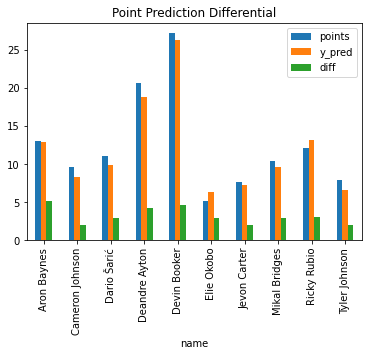

In [8]:
jazz = test.loc[test['team'] == "phoenix_suns", ['name', 'points', 'y_pred', 'diff']].copy()
jazz.groupby('name')[['points', 'y_pred', 'diff']].mean().round(2).plot(kind='bar',
                                                                        title='Point Prediction Differential')

<AxesSubplot:title={'center':'Frequency of Mean Absolute Point Differential'}>

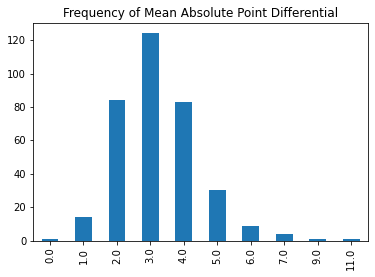

In [9]:
mae_player = test.groupby('name')['diff'].mean()
mae_player.round().value_counts().sort_index().plot(kind="bar", title = "Frequency of Mean Absolute Point Differential")

## Predicting Next Game Performance

We now want to see how many points each player will score in the next game on 08/01/2020. We use the NBA schedule to create a dataset, and take the rolling averages from the last game that the Jazz played (07/30/2020). We then construct the rolling averages, as well as find the opponent points allowed, then feed it into the model to predict. Doing so, we create a plot, and notice that Donovan Mitchell is posed to score higher than his season average, and that Clarkson and Ingles are key contributors, as well as Bodganovic if he was healthy. 

In [ ]:
X_train = df.drop(['date', 'slug', 'name', 'team', 'opponent', 'points'], axis = 1)
y_train = df['points'].values
clf = clf.fit(X_train,y_train)

In [ ]:
team = 'utah_jazz'
# temp_schedule = schedule.copy()
schedule = temp_schedule.copy()
schedule['home_team'] = schedule['home_team'].astype(str)
schedule['home_team'] = list(map(lambda x: x.replace('Team.', '').lower(), schedule['home_team'].values))
schedule['away_team'] = schedule['away_team'].astype(str)
schedule['away_team'] = list(map(lambda x: x.replace('Team.', '').lower(), schedule['away_team'].values))
schedule['start_time'] = pd.to_datetime(schedule['start_time']).dt.strftime('%Y-%m-%d')
schedule = schedule.rename(columns = {'start_time' : 'date'})

home = schedule[(schedule['home_team'] == team) & (schedule['date'] > '2020-08-02')].copy()
away = schedule[(schedule['away_team'] == team) & (schedule['date'] > '2020-08-02')].copy()
away = away.rename(columns = {'away_team' : 'team', 'home_team': 'opponent'})
home = home.rename(columns = {'home_team' : 'team', 'away_team': 'opponent'})
home['home'] = 1
home['away'] = 0
away['home'] = 0
away['away'] = 1
rolling_opp_def = pd.DataFrame(model_df.groupby('team').tail(rolling_constant).groupby('team')['opp_score'].mean()).reset_index().rename(columns = {'team': 'opponent', 'opp_score': 'moving_opp_def'})
predict = pd.concat([home, away]).sort_index()

In [ ]:
bubble = model_df[model_df['team'] == team].groupby('name').tail(1).drop(['date', 'opponent', 'home', 'away'], axis = 1)
drop_columns = ['outcome', 'seconds_played', 'made_field_goals','attempted_field_goals', 
                'made_three_point_field_goals','attempted_three_point_field_goals', 'made_free_throws',
                'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds',
                'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'moving_opp_def', 
                'game_score', 'opp_score', 'points', 'outcome', 'home_team_score', 'away_team_score']
predict_df = pd.merge(bubble, predict.head(1), on = 'team', how = 'outer').drop(drop_columns, axis = 1)
predict_df = pd.merge(predict_df, rolling_opp_def, how='left', on = 'opponent')
drop_columns = ['date', 'slug', 'name', 'team', 'opponent']
X_pred = predict_df.drop(drop_columns, axis = 1)


pred_points = clf.predict(X_pred) 
predict_df['pred_points'] = pred_points.round()
predict_df.plot(x = 'name', y = 'pred_points', kind='bar')
predict_df[['name', 'pred_points']]

## Next Steps? 

A limitation of this is the scope of the model. Ideally, I would want to project the performance of a player for more than one game, perhaps even project the performance for the rest of the season. Another obvious restriction is that this model solely is used for predicting the scoring output. This model does not consider other factors such as assists, rebounds, turnovers, fouls, etc. The next steps I would like to pursue would be to create a player evaluation model using play by play data in conjunction with this model to create a more cohesive understanding of players. 

If you have any questions about this, please email me at shravan.ramamurthy@gmail.com or contact me at +1 (408) 242-4395. Thanks and have a great weekend! 